# Exercise 2 - Python: Logistic Regression

## *Part One*: Logistic regression without regularization

Predicting if a student will be accepted into a university based off of two test scores

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize  # Discovering optimal parameters
import matplotlib.pyplot as plt
import seaborn as sns

# For comparing answers
import statsmodels.discrete.discrete_model as sm  # Unregularized
from sklearn.linear_model import LogisticRegression  # Regularized

plt.style.use('ggplot')

%matplotlib inline

In [2]:
df = pd.read_csv('ex2/ex2data1.txt', header=None, names=['Exam1Score', 'Exam2Score', 'Admitted'])

# Inserting additional column for the intercept
df['x0'] = 1

X = df[['x0', 'Exam1Score', 'Exam2Score']]
y = df['Admitted']

# An array of 0s for starting values of theta to be used in many functions
initialTheta = np.zeros(3)

df.head()

,Exam1Score,Exam2Score,Admitted,x0
0,34.623660,78.024693,0,1
1,30.286711,43.894998,0,1
2,35.847409,72.902198,0,1
3,60.182599,86.308552,1,1
4,79.032736,75.344376,1,1


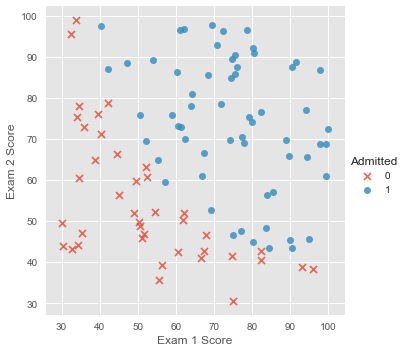

In [3]:
# Plotting the data
sns.lmplot(x='Exam1Score', y='Exam2Score', hue='Admitted',
            data=df, fit_reg=False, markers=["x", "o"])
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')

### Sigmoid Function

$g(z) = \frac{1}{1+e^{-z}}$

Converts $z$ into a value between 0 and 1

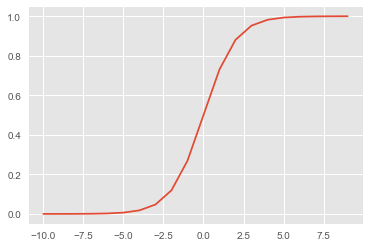

In [4]:
def sigmoid(z):
    """Converts numerical input into a value between 0 and 1"""
    return 1/(1+np.exp(-z))

# Plotting values to validate the function is working correctly
plt.plot(np.arange(-10, 10),
         sigmoid(np.arange(-10, 10)))

### Logistic Regression Hypothesis

$h_\theta(x) = g(\theta^Tx)$

- Notation:

    - $g$: Sigmoid function

    - $\theta^T$: Transposed parameters
       
        - E.x.: $\theta^T = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}$

In [5]:
def logistic_hypothesis(theta, x):
    """
    Calculates the hypothesis for X given values of
    theta for logistic regression
    """
    return sigmoid(x.dot(theta))

logistic_hypothesis(theta=initialTheta, x=X.head())

0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
dtype: float64

### Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))]$

- Notation:

    - $m$: Number of records

    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [6]:
def cost_function(theta, X, y):
    """Computes cost for logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)
    error = np.sum(-y*np.log(h)-(1-y)*np.log(1-h))
    J = (1/m)*error
    return J

cost_function(theta=initialTheta, X=X, y=y)

0.693147180559946

### Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$

- Notation:

    - $\partial$: Partial derivative
    
    - $J(\theta)$: Cost given $\theta$

    - $m$: Number of records
    
    - $h_\theta$: Logistic hypothesis $(h)$ given specific values of $\theta$ for parameters
    
    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)
    
We won't actually be using this function to find the optimal values of $\theta_j$, so this is just illustrating the gradient

In [7]:
def gradient(theta, X, y):
    """Computes the gradient for logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)
    return (1/m)*(np.dot(X.values.T, (h.subtract(y, axis=0))))

gradient(theta=initialTheta, X=X, y=y)

array([ -0.1       , -12.00921659, -11.26284221])

Finding the optimal values of $\theta_j$ for the cost function using scipy's fmin function from their optimize suite.  This is similar to MATLAB's fminunc function.

In [8]:
# Find values of theta that minimize the cost function
optimalTheta = optimize.fmin(func=cost_function,  # Function to minimize
                             x0=initialTheta,  # Initial guess
                             args=(X, y))  # Additional Arguments

# Pretty printing the obtained values for theta
print('\nOptimal Thetas:')
for theta in enumerate(optimalTheta):
    print('Theta', theta[0], ':', theta[1])
    
print('\nCost:', cost_function(optimalTheta, X, y))

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287

Optimal Thetas:
Theta 0 : -25.1613006236
Theta 1 : 0.206231420869
Theta 2 : 0.201471428635

Cost: 0.20349770159021519


Comparing the obtained parameters to what statsmodels provides

Using statsmodels instead of scikit-learn due to scikit-learn automatically regularizing the parameters.  Part one focuses on unregularized logistic regression, and part two focuses on regularized logistic regression.

In [9]:
# Training the model
model = sm.Logit(y, X)

# Outputting model parameters
model = model.fit().params
model

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations 9


x0           -25.161334
Exam1Score     0.206232
Exam2Score     0.201472
dtype: float64

Those are very close!

Calculating the class probability and generating predictions of acceptance using values of $\theta_j$ obtained from the optimization function

The outputs from logistic regression are just the class probability, or $P(y = 1 \mid x; \theta)$, so we are predicting the classes (accepted or not) as follows:

$Prediction(y \mid x; \theta) = \begin{cases} 1, \quad\mbox{ if } P(y = 1 \mid x; \theta) > 0.50 \\ 0, \quad\mbox{ if } P(y = 1 \mid x; \theta) \leq 0.50 \end{cases} $

In [10]:
# Predicting the class probability with the obtained thetas
df['ClassProbability'] = logistic_hypothesis(optimalTheta, X)

# Assigning those with a class probability above 0.5 as admitted
df['Prediction'] = np.where(df['ClassProbability'] > 0.5, 1, 0)

df.head()

,Exam1Score,Exam2Score,Admitted,x0,ClassProbability,Prediction
0,34.623660,78.024693,0,1,0.091035,0
1,30.286711,43.894998,0,1,0.000042,0
2,35.847409,72.902198,0,1,0.043909,0
3,60.182599,86.308552,1,1,0.990425,1
4,79.032736,75.344376,1,1,0.998199,1


Plotting the decision boundary over the data

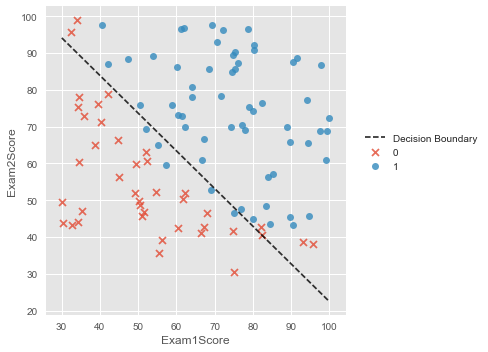

In [11]:
# Plotting the data
sns.lmplot(x='Exam1Score', y='Exam2Score', hue='Admitted',
            data=df, fit_reg=False, markers=["x", "o"], legend=False)

# Calculating and plotting the decision boundary
decisionX = np.array([X['Exam1Score'].min(), X['Exam1Score'].max()])
decisionY = (-1/optimalTheta[2])*(optimalTheta[0] + optimalTheta[1]*decisionX)
plt.plot(decisionX, decisionY, label='Decision Boundary',
         color='black', alpha=0.8, linestyle='--')

# Adjusting the legend location
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

---

##  **Part 2:** Logistic regression with regularization

Predicting if a microchip passes QA after two tests

In [12]:
df = pd.read_csv('ex2/ex2data2.txt', header=None, names=['Test1', 'Test2', 'Accepted'])

df.head()

,Test1,Test2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


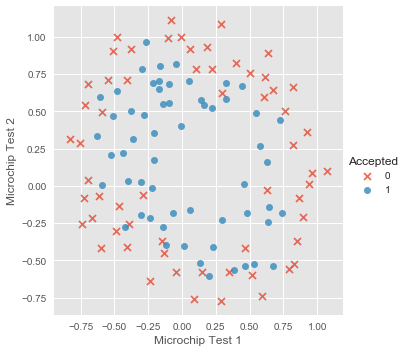

In [13]:
sns.lmplot(x='Test1', y='Test2', hue='Accepted',
            data=df, fit_reg=False, markers=['x', 'o'])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

### Feature Mapping

Maps the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.  This allows for a more complex and nonlinear decision boundary.  

The feature space prior to feature mapping (3-dimensional vector): 

$\hspace{1cm} Feature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix}$ 

The feature space after feature mapping:

$\hspace{1cm} mapFeature(x) = \begin{bmatrix} 1 \\ x_1 \\ x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2 \\ x_1^3 \\ \vdots \\ x_1x_2^5 \\ x_2^6 \end{bmatrix}$

**Note 1:** scikit-learn's [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) function could accomplish this, but we would lose the identifiers for the individual features without a few fancy tricks

**Note 2:** The Octave/MATLAB code provided for this assignment resulted in a 28-dimensional feature space, but our code will result in a 49-dimensional feature space.  This is because the Octave/MATLAB code provided *some* interaction terms (e.x. $x_1x_2,\ x_1^3x_2^4$, etc.), but not all possible interaction terms.  For simplicity, we'll use all interaction terms.

Octave/MATLAB code:
```
degree = 6;
out = ones(size(X1(:,1)));
for i = 1:degree
    for j = 0:i
        out(:, end+1) = (X1.^(i-j)).*(X2.^j);
    end
end
```

Corresponding Python code:
```
for i in range(1, degree):
    for j in range(0, i):
        df['poly' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
```

In [14]:
X = df[['Test1', 'Test2']].copy()

y = df['Accepted'].copy()

# Creating function for use in plotting decision boundaries later
def map_features(X, degree=1):
    """
    Maps the powers for X up to the degree specified, and appends them to X
    Includes interaction terms and the intercept
    """
    for i in range(1, degree+1):
        for j in range(i+1):
            
            # Assigning names to the columns
            if j == 0:
                if i == 1:
                    colName = 'x1'
                else:
                    colName = 'x1_'+str(i)
            elif (i-j) == 0:
                if j == 1:
                    colName = 'x2'
                else:
                    colName = 'x2_'+str(j)
            else:
                colName = 'x1_'+str(i-j)+':'+'x2_'+str(j)
                
            # Calculating polynomial features
            X[colName] = np.power(X.iloc[:, 0],i-j) * np.power(X.iloc[:, 1],j)
    
    X = X.iloc[:, 2:]  # Removing original columns to keep naming conventions
    X.insert(0, 'x0', 1)  # Inserting the intercept term
    return X

X = map_features(X, degree=6)

# Creating a new list of initial thetas
initialTheta = np.zeros(X.shape[1])
            
print('Dimensions:', X.shape)
X.head()

Dimensions: (118, 28)


,x0,x1,x2,x1_2,x1_1:x2_1,x2_2,x1_3,x1_2:x2_1,x1_1:x2_2,x2_3,...,x1_2:x2_3,x1_1:x2_4,x2_5,x1_6,x1_5:x2_1,x1_4:x2_2,x1_3:x2_3,x1_2:x2_4,x1_1:x2_5,x2_6
0,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


### Regularized Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m[-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

The only change from the other cost function we used earlier is the addition of the regularization parameter:

#### Regularization Parameter

$\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

**Note:** $\theta_0$ should not be regularized as denoted by the summation in the regularization parameter

In [15]:
def regularized_cost(theta, X, y, C):
    """Computes cost for regularized logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)
    error = np.sum(-y*np.log(h)-(1-y)*np.log(1-h))
    
    # Calculating the regularization penalty
    # Avoiding the regularization penalty for the first theta
    regularizedTheta = theta[1:] ** 2
    regularization = (C/(2*m))*np.sum(regularizedTheta)
    
    J = (1/m)*error + regularization
    return J

# Testing how cost differs with regularization
# Using thetas above 0 so the regularization parameter has an impact
regTestTheta = np.ones(X.shape[1])/2
print('Cost at lambda=0:', regularized_cost(regTestTheta, X, y, C=0))
print('Cost at lambda=1:', regularized_cost(regTestTheta, X, y, C=1))
print('Cost at lambda=100:', regularized_cost(regTestTheta, X, y, C=100))

Cost at lambda=0: 1.23153120112
Cost at lambda=1: 1.26013289603
Cost at lambda=100: 4.09170069264


### Regularized Gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \hspace{2.25cm}$for $j = 0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

This is also the same as the last gradient with the exception of the regularization parameter

#### Regularization Parameter

$\frac{\lambda}{m}\theta_j \hspace{0.5cm}$for $j \geq 1$

- Notation:

    - $\lambda$: The weight which the parameters are adjusted by.  A lower $\lambda$ has little effect on the parameters, and a higher $\lambda$ (e.x. $\lambda = 1,000$) will adjust the parameters to be close to 0.
    - $m$: Number of records
    - $j$: The index for the parameter.  E.x. $\theta_{j=1}$ is the score for Microchip Test #1

In [16]:
def regularized_gradient(theta, X, y, C=0):
    """Computes the gradient for regularized logistic regression"""
    m = y.size
    h = logistic_hypothesis(theta, X)

    # Calculating the regularization parameter to all thetas but the intercept
    regParam = (C/m)*theta[1:]
    
    gradient = (1/m)*(np.dot(X.values.T, (h.subtract(y, axis=0))))
    gradient[1:] = gradient[1:] + regParam  # Applying the reg parameter
    return gradient

regularized_gradient(initialTheta, X, y, C=1)

array([  8.47457627e-03,   1.87880932e-02,   7.77711864e-05,
         5.03446395e-02,   1.15013308e-02,   3.76648474e-02,
         1.83559872e-02,   7.32393391e-03,   8.19244468e-03,
         2.34764889e-02,   3.93486234e-02,   2.23923907e-03,
         1.28600503e-02,   3.09593720e-03,   3.93028171e-02,
         1.99707467e-02,   4.32983232e-03,   3.38643902e-03,
         5.83822078e-03,   4.47629067e-03,   3.10079849e-02,
         3.10312442e-02,   1.09740238e-03,   6.31570797e-03,
         4.08503006e-04,   7.26504316e-03,   1.37646175e-03,
         3.87936363e-02])

Finding the optimal values of $\theta$.  This chunk will take longer to run since we're dealing with a much higher dimensional dataset.

In [17]:
# Find values of theta that minimize the cost function
optimalTheta = optimize.fmin(func=regularized_cost,  # Function to minimize
                             x0=initialTheta,  # Initial guess
                             args=(X, y, 1),  # Additional Arguments
                             maxiter=4000)

Checking against scikit-learn's logistic regression

In [18]:
# Building and training the model
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X, y)

# Comparing the costs between the obtained parameters
print('Our cost:', cost_function(optimalTheta, X, y))
print('sklearn cost:', cost_function(model.coef_[0], X, y))

# Comparing the parameters themselves
pd.DataFrame({'Ours': optimalTheta,
              'sklearn': model.coef_[0]},
             index=X.columns).transpose()

Our cost: 0.5606563794918066
sklearn cost: 0.505914141308952


,x0,x1,x2,x1_2,x1_1:x2_1,x2_2,x1_3,x1_2:x2_1,x1_1:x2_2,x2_3,...,x1_2:x2_3,x1_1:x2_4,x2_5,x1_6,x1_5:x2_1,x1_4:x2_2,x1_3:x2_3,x1_2:x2_4,x1_1:x2_5,x2_6
Ours,0.733121,0.057183,0.443223,-2.149528,0.017576,-0.324193,0.505240,-0.373438,-0.224623,-0.113880,...,0.360670,0.715639,0.13414,-0.337966,0.492453,0.296553,0.088575,-0.463015,0.610091,-0.736941
sklearn,0.601813,0.612629,1.173697,-1.941600,-0.916522,-1.346001,0.125384,-0.367177,-0.350874,-0.174398,...,-0.279071,-0.290913,-0.46305,-1.039417,0.028535,-0.292513,0.016490,-0.328181,-0.140750,-0.928454


Scikit-learn's function unsurprisingly found much better parameters.  It also executed much quicker due to being properly optimized.  I guess I shouldn't try contributing to scikit-learn anytime soon.

Lastly, comparing the accuracy between the two models.  Classification accuracy is just the percentage of records correctly classified (precision, recall, f-1 score, etc. offer more nuanced information on performance), so we will have to calculate the class probabilities and assign predictions like we did for part one:

In [19]:
# Predicting the class probability with the obtained thetas
df['ClassProbability'] = logistic_hypothesis(optimalTheta, X)

# Assigning those with a class probability above 0.5 as admitted
df['Prediction'] = np.where(df['ClassProbability'] > 0.5, 1, 0)

df.head()

,Test1,Test2,Accepted,ClassProbability,Prediction
0,0.051267,0.69956,1,0.638683,1
1,-0.092742,0.68494,1,0.640282,1
2,-0.213710,0.69225,1,0.617558,1
3,-0.375000,0.50219,1,0.612683,1
4,-0.513250,0.46564,1,0.531008,1


In [20]:
print('Our Accuracy:', np.where(df['Accepted'] == df['Prediction'], 1, 0).mean())
print('Scikit-learn Accuracy:', model.score(X,y))

Our Accuracy: 0.737288135593
Scikit-learn Accuracy: 0.830508474576


Our model also had a accuracy like we would have expected.  

Plotting the Decision Boundary using inspiration from [this post](https://www.kunxi.org/notes/machine_learning/logistic_regression/)

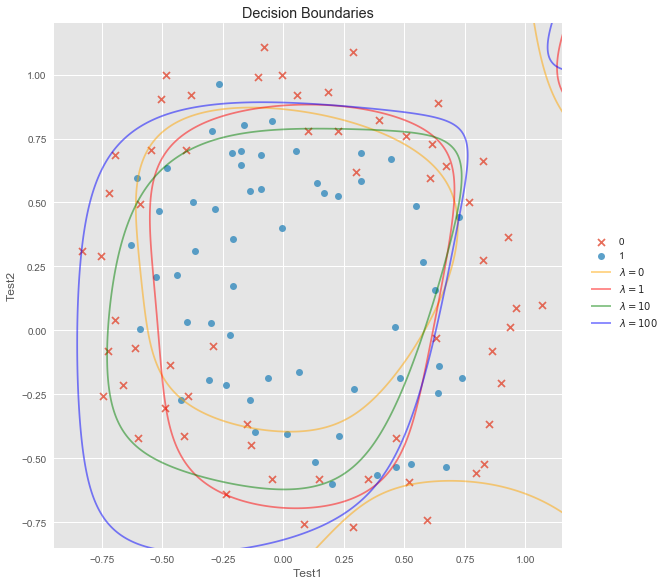

In [21]:
def plot_boundary(X, y, C=0, color='orange'):
    """
    Returns arguments used for plotting the decision boundary.
    Uses the optimization function to find the optimal values of
    theta, so it is not needed as a parameter.
    """
    # Find values of theta that minimize the cost function
    optimalTheta = optimize.fmin(func=regularized_cost,  # Function to minimize
                                 x0=initialTheta,  # Initial guess
                                 args=(X, y, C),  # Additional Arguments
                                 maxiter=4000)
    
    # Creating the meshgrid to generate class probabilities for
    dim = np.linspace(-1, 1.5, 1000)
    dx, dy = np.meshgrid(dim, dim)
    
    # Mapping polynomial features over the mesh grid
    v = pd.DataFrame({'v1': dx.flatten(), 'v2': dy.flatten()})
    v = map_features(v, degree=6)
    
    # Generating the class probabilities for the mesh grod
    z = (logistic_hypothesis(optimalTheta, v)).values.reshape(1000, 1000)
    
    # Plotting the boundary for 0.5 probability with a contour plot
    boundary = plt.contour(dx, dy, z, levels=[0.5], colors=color, alpha=0.5)
    return boundary


# Required to combine all plots
plt.figure()

# Plotting the original data
sns.lmplot(x='Test1', y='Test2', hue='Accepted',
           data=df, fit_reg=False, markers=['x', 'o'],
           legend=False, size=8)

plt.title('Decision Boundaries')

# Plotting the decision boundaries at various values of lambda
lambda0 = plot_boundary(X, y)
lambda0.collections[0].set_label('$\lambda = 0$')

lambda1 = plot_boundary(X, y, C=1.0, color='red')
lambda1.collections[0].set_label('$\lambda = 1$')

lambda10 = plot_boundary(X, y, C=10.0, color='green')
lambda10.collections[0].set_label('$\lambda = 10$')

lambda100 = plot_boundary(X, y, C=100.0, color='blue')
lambda100.collections[0].set_label('$\lambda = 100$')

# Adjusting the axes
plt.axis([-0.95, 1.15, -0.85, 1.20])

# Adjusting the legend location
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)